In [19]:
#Set up DrWatson
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
# Load relevant fuctions
include("/home/jm2386/Active_Lattice/src/pm_pde_functions.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");
include("/home/jm2386/Active_Lattice/src/plot_functions.jl");


loaded


In [41]:
# set parameters
params = []
Pe = 7.5
pert = "pm_lin"
    T = 0.05
    save_interval = 0.001
    δ  = 1e-4
    Dx = 1. 
    Dθ = 400.0
    Nx = 2^10
    Nθ = 2
    δt = 1e-8
#
#load binodal values
name = "pm_pde_binodal+pert_run_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
data = wload(filename)
@unpack Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs = data
#create params
params = []
γ_length = length(γs)
n_lines = 40
interval = Int(round(γ_length/n_lines))
γs          = γs[interval:(2*interval):Int64(round(γ_length))]
γs = [γ for γ in γs if γ ≤ 2.2]
average_ϕs  = average_ϕs[interval:(interval):Int64(round(γ_length))]
γ_length = length(γs)
average_ϕs = average_ϕs[1:γ_length]
map(average_ϕs, γs) do ρ, γ
        χ = (1-γ*(1-ρ))/ρ
        param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = δt, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
        )
        push!(params,param)
end
γ_length



15

In [5]:
i = 1
param = params[i]
γ = γs[i]

initial_Δ = 1e-4;
max_iter = 40;
tol = 1e-15;
atol = 1e-12;
rho_max = (1-10e-20);

find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
ϕg = lower_limits[1]
ϕl = upper_limits[1]
ϕg, ϕl 

(0.19285765519782042, 0.9459138379841288)

In [7]:
#define problem
using DifferentialEquations

function f(du,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    du[1] = Pe*(1-u[1])*u[2]
    du[2] = -Pe*u[2]^2 + Pe*( (1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1]) -(2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])
    return du
end

function f_jac(J,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    J[1,1] = -Pe*u[2]
    J[1,2] =  Pe*(1-u[1])
    J[2,1] =  self_diff_prime(u[1])*            (2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])^2              + (2/Pe)/(1-u[1])/self_diff(u[1])
    J[2,1] += self_diff_prime(u[1])*Pe*((1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1])^2  + Pe*(γ*self_diff(u[1]) +(1-γ*(1-u[1]))*self_diff_prime(u[1]) )/self_diff(u[1])
    J[2,2] = -2*Pe*u[2]
    return J
end

#compute solution
J = zeros(2,2)
u = zeros(2)
parameters = (Pe, γ, ϕg, ϕl)
t = 0.
J = f_jac(J,u,parameters,t)
values, vectors = eigen(J)
evector2 = vectors[:,2]

ff = ODEFunction(f;jac=f_jac)
ϵ = 1e-10
initial_position = [ϕg, 0.0] + ϵ*evector2
time_interval = (0.0, 100.0)

ff = ODEFunction(f;jac=f_jac)
prob = ODEProblem(ff,initial_position,time_interval, parameters)

sol = DifferentialEquations.solve(prob,abstol = 1e-15, reltol = 1e-15);

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/jm2386/.julia/packages/SciMLBase/kTUaf/src/integrator_interface.jl:580


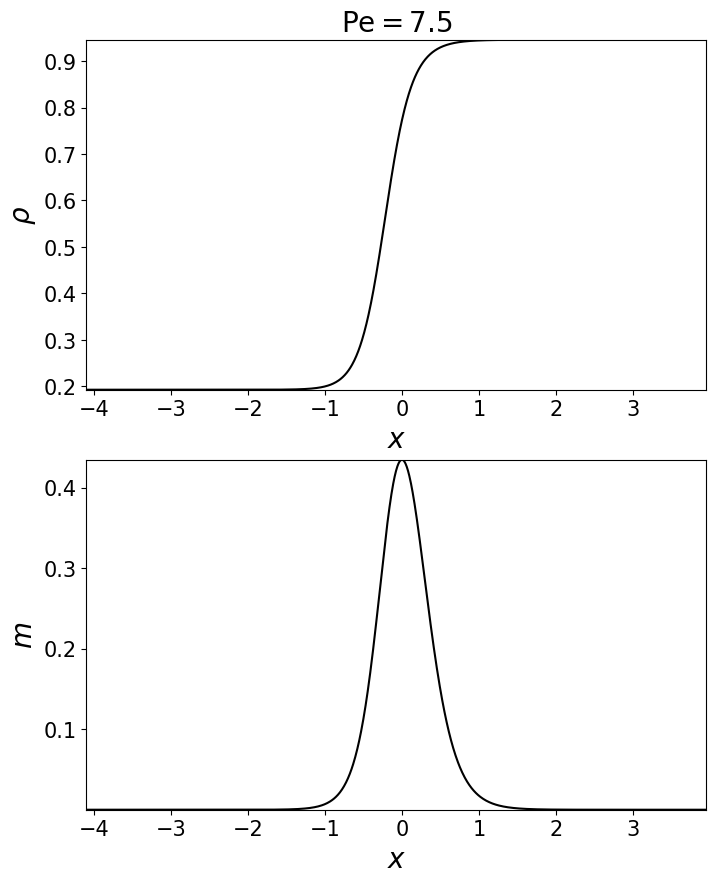

0.0
8.061702819223171


In [8]:
#check if m<0 or rho> phil
sol_len = length(sol.t)
ind_max = 1
while (sol[1,ind_max]< ϕl)&&(sol[2,ind_max] ≥0)&&(ind_max<sol_len)
    ind_max += 1
end
#find central time
t_mid_arg = argmax(sol[2,1:ind_max])
t_middle = sol.t[t_mid_arg]
t_max = maximum(sol.t[1:ind_max].-t_middle)
t_min = minimum(sol.t[1:ind_max].-t_middle)
t_lim = round(min(t_max, - t_min))
t_max_index = argmax(sol.t[1:ind_max].-t_middle)
t_min_index = argmin(sol.t[1:ind_max].-t_middle)
println(sol.t[t_min_index])
println(sol.t[t_max_index])
#plot figure
PyPlot.close("all")
fig, axs = plt.subplots(2, 1, figsize=(8,10))
xlabels = [L"\rho", L"m"]
for i in 1:2
    ax = axs[i]
    ax.plot(sol.t[t_min_index:t_max_index].-t_middle, sol[i,t_min_index:t_max_index], color = "black")
    axlim = [ t_min, t_max, minimum(sol[i,t_min_index:t_max_index]), maximum(sol[i,t_min_index:t_max_index])]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_ylabel(xlabels[i],fontsize=20)
    ax.set_xlabel(L"x",fontsize=20)
end
fig_title = latexstring("\$ \\mathrm{Pe} = $(Pe) \$")
axs[1].set_title(fig_title,fontsize=20)
display(fig)

In [28]:
function bump_funciton(x; ϵ = 1, x0 = 0.)
    if (-1<((x-x0)/ϵ)<1)
        return exp(-1/(1-((x-x0)/ϵ)^2))/ϵ
    else
        return 0
    end
end

function initialize_bin_pm(param::Dict{String,Any}; )
    @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    ϕa = ρa
    ϕp = ρp
    initial_Δ = 1e-4;
    max_iter = 40;
    tol = 1e-3;
    atol = 1e-12;
    rho_max = (1-10e-20);
    γ = (1-ϕa)/(1-ρ);

    find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
    ϕg = lower_limits[1]
    ϕl = upper_limits[1]

    ϕag, ϕpg = gamma_converter(γ, ϕg)
    ϕal, ϕpl = gamma_converter(γ, ϕl)

    density = Dict{String,Any}()
    fa = fill(ϕag/(2),(Nx,Nθ))
    fp = fill(ϕpg,(Nx))
    Nx2 = Int64(round(Nx/2))
    fa[1:Nx2,:] = fill(ϕal/(2),(Nx2,Nθ))
    fp[1:Nx2] = fill(ϕpl,(Nx2))
    t = 0.
    @pack! density = fa , fp, t
    return density
end

function smooth_density(param,density)
    @unpack name, Dx, Dθ, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    @unpack t, fa, fp = density 
    
    mollifier = bump_funciton.((1:Nx)/Nx; ϵ = 5*sqrt(Dx/Dθ), x0 = 1/2)
    mollifier = mollifier/sum(mollifier)

    Nx2 = Int64(round(Nx/2))

    fa2 = zeros(Nx,2)
    fp2 = zeros(Nx)
    for i in 1:Nx, j in 1:Nx
        ## k = i - j 
        k = (i-j +Nx2 +Nx -1 )%Nx +1
        fa2[i,1] += mollifier[k].*fa[j,1]
        fa2[i,2] += mollifier[k].*fa[j,2]
        fp2[i]   += mollifier[k].*fp[j]
    end

    density = Dict{String,Any}()
    fa = fa2
    fp = fp2
    t = 0.
    @pack! density = fa , fp, t
    return density
end


function initialize_arctan_pm(param::Dict{String,Any}; )
    @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    ϕa = ρa
    ϕp = ρp
    ϕ = ϕa+ϕp
    initial_Δ = 1e-4;
    max_iter = 40;
    tol = 1e-3;
    atol = 1e-12;
    rho_max = (1-10e-20);
    γ = (1-ϕa)/(1-ϕ);

    find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
    ϕg = lower_limits[1]
    ϕl = upper_limits[1]

    ϕag, ϕpg = gamma_converter(γ, ϕg)
    ϕal, ϕpl = gamma_converter(γ, ϕl)


    l = sqrt(Dx/Dθ)
    ϵ = 2.0
    
    density = Dict{String,Any}()

    ρa  = (ϕal-ϕag)*(  tanh.( (collect(1:Nx)/Nx .-0.75)/ϵ/l )/2 .+0.5) .+ ϕag
    fp  = (ϕpl-ϕpg)*(tanh.( (collect(1:Nx)/Nx .-0.75)/ϵ/l )/2 .+0.5) .+ ϕpg
    ρ = ρa+fp

    m   = (ϕl-ϕg)*( -tanh.( (collect(1:Nx)/Nx .-0.75)/ϵ/l ).^2 .+1 )/2 ./(-ρ.+1)/λ/l/ϵ

    Nx2 = Int64(round(Nx/2))
    ρa[1:Nx2]  = -(ϕal-ϕag)*(  tanh.( (collect(1:Nx2)/Nx .-0.25)/ϵ/l )/2 .+0.5  ) .+ ϕal
    fp[1:Nx2] = -(ϕpl-ϕpg)*(tanh.( (collect(1:Nx2)/Nx .-0.25)/ϵ/l )/2 .+0.5  ) .+ ϕpl
    ρ = ρa+fp
    m[1:Nx2]  = -(ϕl-ϕg)*( -tanh.( (collect(1:Nx2)/Nx .-0.25)/ϵ/l ).^2 .+1 )/2 ./(-ρ[1:Nx2].+1)/λ/l/ϵ
    

    fa = zeros(Nx,2)
    fa[:,1] = (ρa - m)/2
    fa[:,2] = circshift((ρa + m)/2,0)
    t = 0.

    @pack! density = fa , fp, t
    return density
end


function initialize_sol_pm(param::Dict{String,Any}, sol, ϕg, ϕl, γ;)
   @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    γ = (1-ρa)/(1-ρa-ρp);
    #find central time
    t_mid_arg = argmax(sol[2,:])
    t_middle = sol.t[t_mid_arg]
    t_max = maximum(sol.t[:].-t_middle)
    t_min = minimum(sol.t[:].-t_middle)
    t_lim = round(min(t_max, - t_min))
    #t_lim_index = argmin(abs.(sol.t[:].-2*t_lim))
    
    l = sqrt(Dx/Dθ)
    density = Dict{String,Any}()
    
    ρ = fill(ϕg, Nx)
    m = fill(0., Nx)
    
    Nx4  = Int64(round(Nx/4))
    Nx2  = 2*Nx4
    Nx34 = 3*Nx4
    
    ρ[(Nx4+1):1:Nx34] = fill(ϕl, Nx2)
    
    n_index = min(Int64(round(t_lim*l*Nx)),Nx4)
    
    ts1 = collect((1:(2*n_index))/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    ts2 = collect(((2*n_index):(-1):1)/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    
    sol_index_1 = (Nx4-n_index+1):1:(Nx4+n_index)
    sol_index_2 = (Nx34-n_index+1):1:(Nx34+n_index)
    
    ρ[sol_index_1] = sol.(ts1, idxs = 1)
    m[sol_index_1] = sol.(ts1, idxs = 2)
    
    ρ[sol_index_2] =  sol.(ts2, idxs = 1)
    m[sol_index_2] = -sol.(ts2, idxs = 2)
    
    ρa = γ*(ρ .- 1) .+1
    fp = ρ - ρa
    fa = zeros(Nx,2)
    fa[:,1] = (ρa - m)/2
    fa[:,2] = (ρa + m)/2
    t = 0.
    
    @pack! density = fa , fp, t
    return density
end

function spatial_currents_pm(fa_saves, fp_saves; param = param)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe,λ  = param
    ja_saves, jp_saves = [], []
    for i in eachindex(fa_saves)
        fa = fa_saves[i]
        fp =  fp_saves[i]

        ρ::Array{Float64,1} = fp + sum(fa; dims =2)[:,1]
    
        Ua::Array{Float64,2},   Up::Array{Float64,1} = U_velocities_pm(fa,fp,ρ; Nx=Nx, Nθ=Nθ, λ=λ,γ=γ)
        moba::Array{Float64,2}, mobp::Array{Float64,1} = mob_pm(fa,fp,ρ;γ=γ)
        Fa::Array{Float64,2},   Fp::Array{Float64,1}  = F_fluxes_pm(Ua, Up, moba, mobp; Nx=Nx, Nθ=Nθ)
        
        ja = sum(Fa; dims =2)[:,1]
        jp = Fp
        push!(ja_saves,ja)
        push!(jp_saves,jp)
    end
    return ja_saves, jp_saves
end

using DifferentialEquations

function f(du,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    du[1] = Pe*(1-u[1])*u[2]
    du[2] = -Pe*u[2]^2 + Pe*( (1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1]) -(2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])
    return du
end

function f_jac(J,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    J[1,1] = -Pe*u[2]
    J[1,2] =  Pe*(1-u[1])
    J[2,1] =  self_diff_prime(u[1])*            (2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])^2              + (2/Pe)/(1-u[1])/self_diff(u[1])
    J[2,1] += self_diff_prime(u[1])*Pe*((1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1])^2  + Pe*(γ*self_diff(u[1]) +(1-γ*(1-u[1]))*self_diff_prime(u[1]) )/self_diff(u[1])
    J[2,2] = -2*Pe*u[2]
    return J
end

function initialize_sol_pm_full(param::Dict{String,Any})
    @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, Pe, Dx, Dθ= param
    #copmute binodal values

    ϕa = ρa
    ϕp = ρp
    ϕ = ϕa+ϕp

    # compute binodal
        initial_Δ = 1e-4;
        max_iter = 40;
        tol = 1e-15;
        atol = 1e-12;
        rho_max = (1-10e-20);

        find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
        ϕg = lower_limits[1]
        ϕl = upper_limits[1]
    ##
    

    #compute solution
        J = zeros(2,2)
        u = zeros(2)
        parameters = (Pe, γ, ϕg, ϕl)
        t = 0.
        J = f_jac(J,u,parameters,t)
        values, vectors = eigen(J)
        evector2 = vectors[:,2]

        ff = ODEFunction(f;jac=f_jac)
        ϵ = 1e-10
        initial_position = [ϕg, 0.0] + ϵ*evector2
        time_interval = (0.0, 100.0)

        ff = ODEFunction(f;jac=f_jac)
        prob = ODEProblem(ff,initial_position,time_interval, parameters)

        sol = DifferentialEquations.solve(prob,abstol = 1e-15, reltol = 1e-15);
    ##

    #find central time
    #check if m<0 or rho> phil
        sol_len = length(sol.t)
        ind_max = 1
        while (sol[1,ind_max]< ϕl)&&(sol[2,ind_max] ≥0)&&(ind_max<sol_len)
            ind_max += 1
        end
        #find central time
        t_mid_arg = argmax(sol[2,1:ind_max])
        t_middle = sol.t[t_mid_arg]
        t_max = maximum(sol.t[1:ind_max].-t_middle)
        t_min = minimum(sol.t[1:ind_max].-t_middle)
        t_lim = round(min(t_max, - t_min))
        t_max_index = argmax(sol.t[1:ind_max].-t_middle)
        t_min_index = argmin(sol.t[1:ind_max].-t_middle)
    ##


    l = sqrt(Dx/Dθ)
    density = Dict{String,Any}()
    
    ρ = fill(ϕg, Nx)
    m = fill(0., Nx)
    
    Nx4  = Int64(round(Nx/4))
    Nx2  = 2*Nx4
    Nx34 = 3*Nx4
    
    ρ[(Nx4+1):1:Nx34] = fill(ϕl, Nx2)
    
    n_index = min(Int64(round(t_lim*l*Nx)),Nx4)
    
    ts1 = collect((1:(2*n_index))/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    ts2 = collect(((2*n_index):(-1):1)/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    
    sol_index_1 = (Nx4-n_index+1):1:(Nx4+n_index)
    sol_index_2 = (Nx34-n_index+1):1:(Nx34+n_index)
    
    ρ[sol_index_1] = sol.(ts1, idxs = 1)
    m[sol_index_1] = sol.(ts1, idxs = 2)
    
    ρ[sol_index_2] =  sol.(ts2, idxs = 1)
    m[sol_index_2] = -sol.(ts2, idxs = 2)
    
    ρa = γ*(ρ .- 1) .+1
    fp = ρ - ρa
    fa = zeros(Nx,2)
    fa[:,1] = (ρa - m)/2
    fa[:,2] = (ρa + m)/2
    t = 0.
    
    @pack! density = fa , fp, t
    return density
end

function perturb_pde_pm!(param::Dict{String,Any}, density::Dict{String,Any}; δ = 0.01, pert = "n=2")
    @unpack Nx, S, ρa, ρp, λ, Dθ, Nx, Nθ,Dx,Pe,Dθ,k, γ = param
    @unpack fa, fp = density
    ρ = ρa + ρp
    if ρ >0.99
        δ = min(δ, (1 - ρ)/(2*π+0.01));
    end
    #from stability: 
    if pert == "n=1"
        if ρp >0.
            K = collect(0:1:(k-1))
            matrix = ap_MathieuMatrix(ρa,ρp,Dx,Pe,Dθ; k=k, γ= γ)
            ω = 2*π
            a, A = ap_MathieuEigen(matrix)
            Pa = (x,θ) -> real.( dot(A[2:1:(k+1),k+1],cos.(θ*K*(2*π/Nθ)))*exp(-im*x*ω/Nx) )
            Pp = (x) -> real.(A[1,k+1]*exp(-im*x*ω/Nx));
        else
            K = collect(0:1:(k-1))
            matrix = a_MathieuMatrix(ρa,ρp,Dx,Pe,Dθ; k=k, γ= γ)
            ω = 2*π
            a, A = a_MathieuEigen(matrix)
            Pa = (x,θ) -> real.( dot(A[:,k],cos.(θ*K*(2*π/Nθ)))*exp(-im*x*ω/Nx) )
            Pp = (x) -> 0.;
        end
    end
    if pert == "pm_lin"
        ω, value, vector = pm_lin_pert(param)
        Prho = (x) -> real.( vector[1]*exp(im*x*2*π/Nx) );
        Pact = (x) -> real.( vector[2]*exp(im*x*2*π/Nx) );
        Pmag = (x) -> real.( vector[3]*exp(im*x*2*π/Nx) );
    end
    if pert == "pm_lin_binod"
        ω, value, vector = pm_lin_binod_pert(param)
        Prho = (x) -> real.( vector[1]*exp(im*x*4*π/Nx) );
        Pact = (x) -> real.( vector[2]*exp(im*x*4*π/Nx) );
        Pmag = (x) -> real.( vector[3]*exp(im*x*4*π/Nx) );
    end
    if pert == "rand"
        Pa = (x,θ) -> δ*ρa*(( rand() - 0.5 )/(ρa+0.01))/(2*π);
        Pp = (x) -> δ*ρp*( rand() - 0.5 )/(ρp+0.01);
    end
    #
    if pert == "safe_unif"
        Pa = (x,θ) -> ( rand() - 0.5 )/(2*π);
        Pp = (x) -> ( rand() - 0.5 );
    end
    #
    perta = zeros(Nx,Nθ)
    pertp = zeros(Nx)
    if pert == "safe_unif"
        for x₁ in 1:Nx, θ in S
            ρ = fp[x₁] + sum(fa[x₁,:])*2*π/Nθ
            perta[x₁, θ] += min(10*δ, ρ*(1-ρ)/2)*Pa(x₁, θ)/2;
        end
        for x₁ in 1:Nx
            ρ = fp[x₁] + sum(fa[x₁,:])*2*π/Nθ
            pertp[x₁] += min(10*δ, ρ*(1-ρ)/2)*Pp(x₁)/2;
        end
    elseif pert == "pm_lin"
        for x₁ in 1:Nx
            perta[x₁, 1] += (Pact(x₁)-Pmag(x₁))/2
            perta[x₁, 2] += (Pact(x₁)+Pmag(x₁))/2
            pertp[x₁]    += Prho(x₁)-Pact(x₁)
        end
    elseif pert == "pm_lin_binod"
        for x₁ in 1:Nx
            perta[x₁, 1] += (Pact(x₁)-Pmag(x₁))/2
            perta[x₁, 2] += (Pact(x₁)+Pmag(x₁))/2
            pertp[x₁]    += Prho(x₁)-Pact(x₁)
        end
    else
        for x₁ in 1:Nx, θ in S
            perta[x₁, θ] += Pa(x₁, θ);
        end
        for x₁ in 1:Nx
            pertp[x₁] += Pp(x₁);
        end
        if pert == "rand"
            perta[:, 1:(Nθ-1)]  = 0.5*perta[:, 1:(Nθ-1)] + 0.5*perta[:, (Nθ-1):(-1):1] 
        end
    end

    if pert == "safe_unif"
        fa += perta
        fp += pertp
    else
        c = dist_from_unif_pm(param, perta.+ρa/(2*π), pertp.+ρp)
        fa += δ*perta/c
        fp += δ*pertp/c
    end

    @pack! density = fa, fp;
end

function pm_lin_binod_pert(param)
    @unpack S, ρa, ρp, λ, Nx, Nθ, Dx, Pe, Dθ, γ = param
    ω = 4*π/sqrt(Dθ);
    ϕa = ρa;
    ϕp = ρp;
    ϕ  = ϕa + ϕp;
    ϕ0 = 1- ϕ;
    ds = self_diff(ϕ);
    dsp = self_diff_prime(ϕ);
    DD = (1-ds)/ϕ
    s = DD - 1
    W = [-ω^2             0          -im*ω*Pe*ϕ0; 
        -ω^2*ϕa*DD      -ω^2*ds     -im*ω*Pe*(ϕa*s+ds); 
        -im*ω*Pe*ϕa*dsp -im*ω*Pe*ds -ω^2*ds-2         ]
    values,vectors = eigen(W)
    return ω, values[3], vectors[:,3]
end



pm_lin_binod_pert (generic function with 1 method)

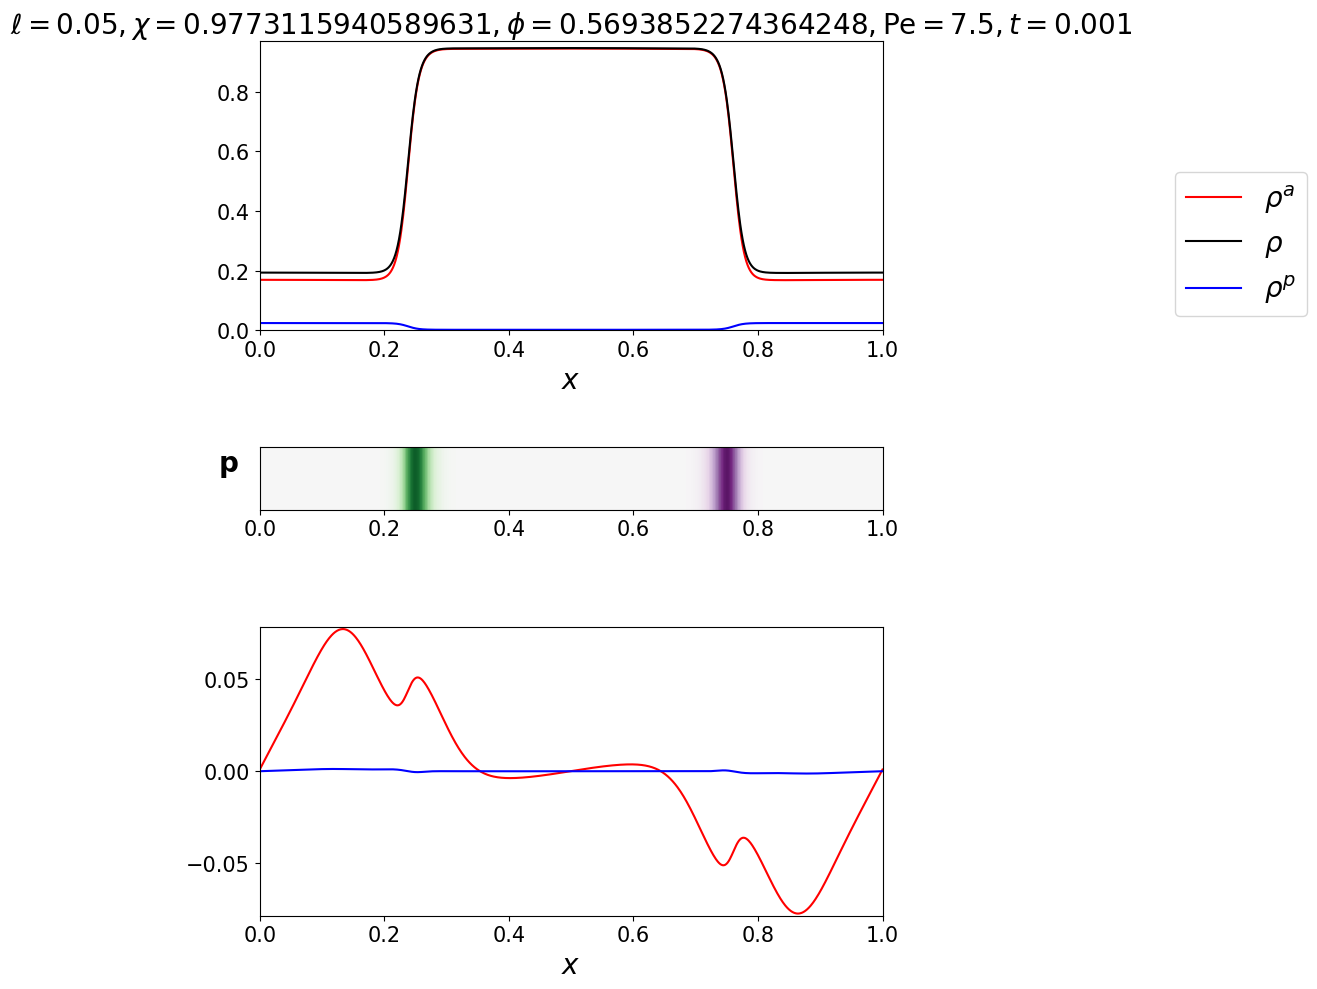

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/jm2386/.julia/packages/SciMLBase/kTUaf/src/integrator_interface.jl:580


0.0010000999999997715

In [51]:
#Select param
i = 1
param = params[i]
γ = γs[i]

#plot density 
using PyPlot
@unpack T, save_interval, max_steps, pert, Nx= param
Nx = 2^10
pert = "pm_lin_binod"
δ = 1e-3
δt = 1e-7
@pack! param= Nx, δ, pert, δt 

density = initialize_sol_pm_full(param)
#density = initialize_density_pm(param)
perturb_pde_pm!(param,density; δ = δ, pert = pert)

run_pde_until_pm!(param,density,1e-3; save_on = true, max_steps = max_steps, save_interval = save_interval)

@unpack t, fa, fp = density
# n = length(t_saves)
# t, fa, fp = t_saves[n], fa_saves[n], fp_saves[n]
fig, axs = plt.subplots(3, 1, figsize=(10,10))
vid_pde_plot_pm_plus(fig, axs, param, [t], [fa], [fp], 1)
display(fig)
t


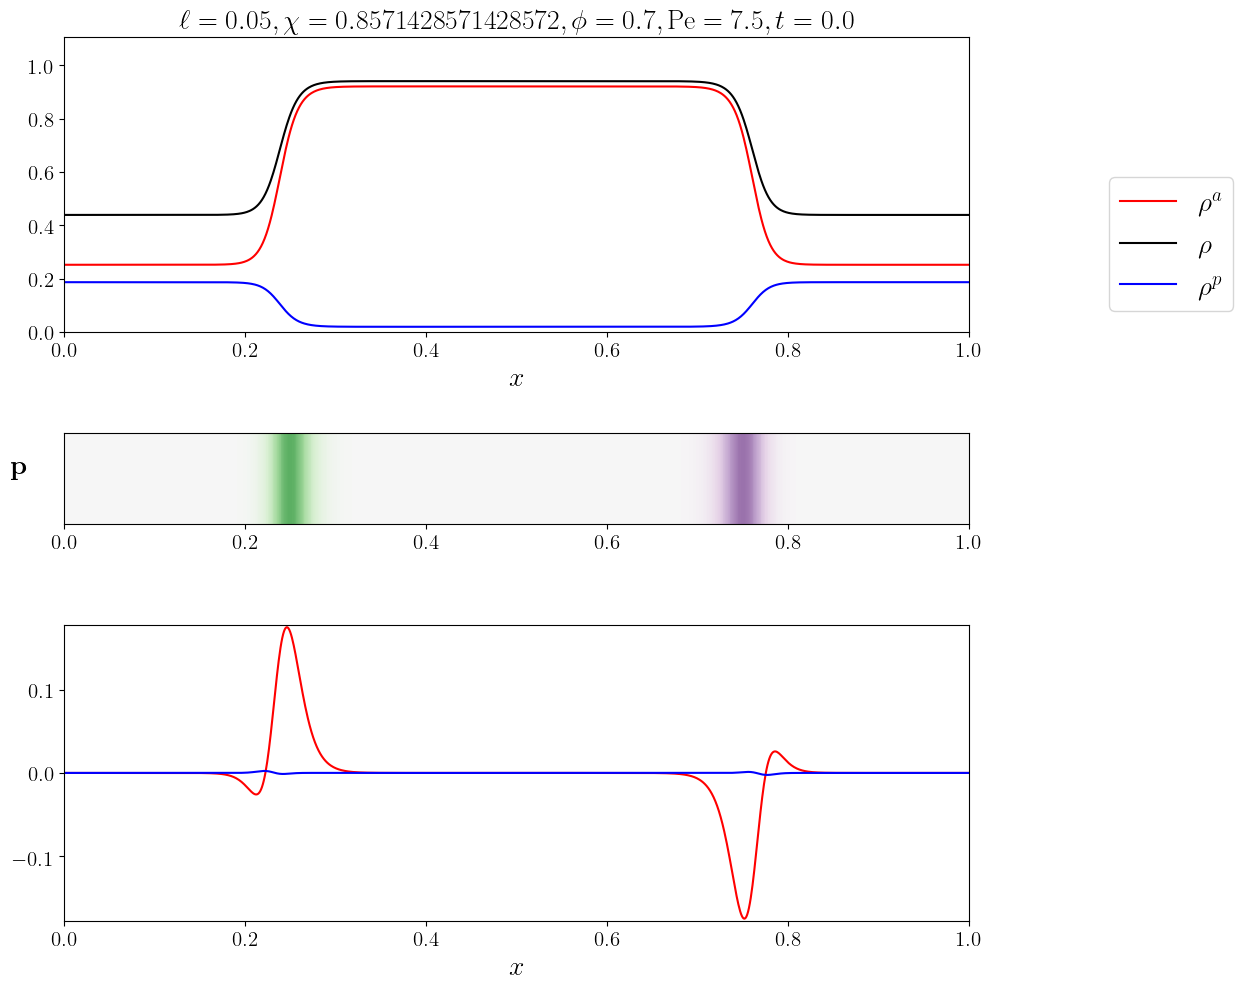

1024

In [386]:
@unpack t, fa, fp = density
# n = length(t_saves)
# t, fa, fp = t_saves[n], fa_saves[n], fp_saves[n]
fig, axs = plt.subplots(3, 1, figsize=(10,10))
vid_pde_plot_pm_plus(fig, axs, param, [t], [fa], [fp], 1)
display(fig)
Nx

1.1199999999999903e-5

In [385]:
for i in 1:100
    pde_stepper_pm!(param,density)
end


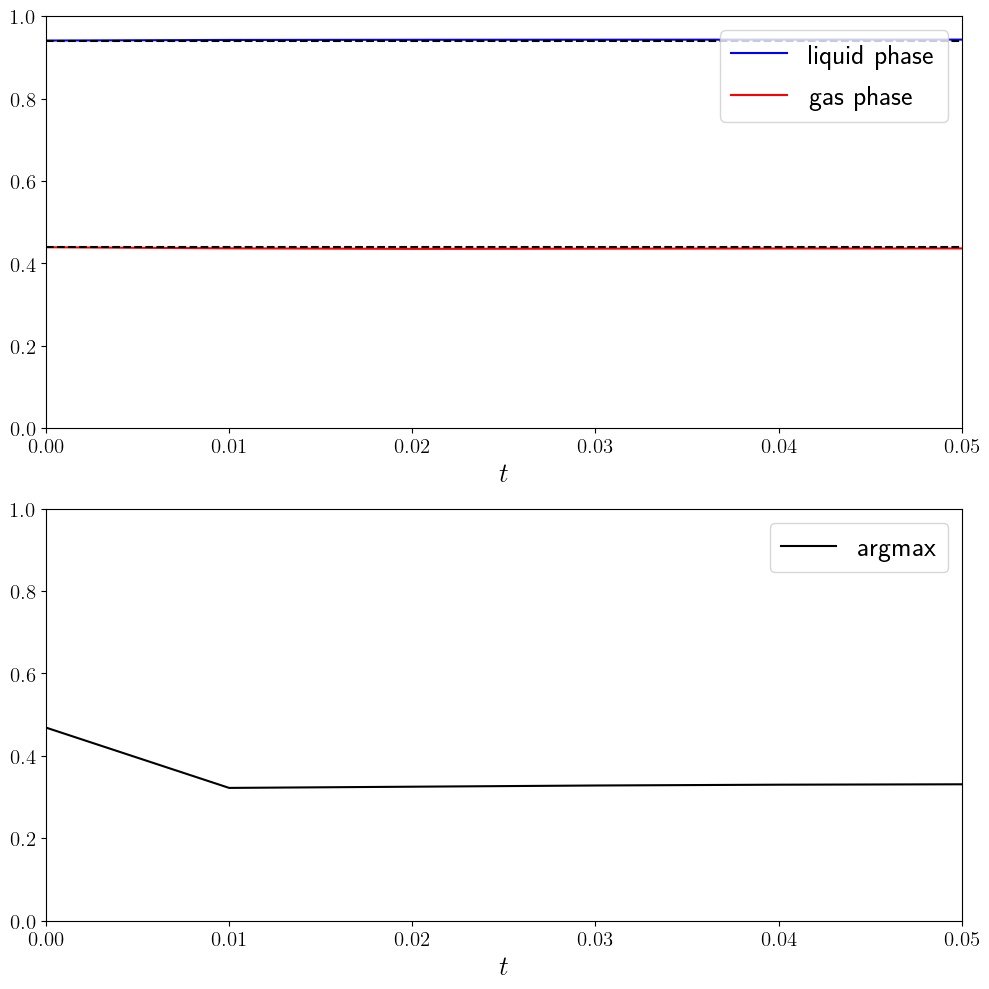

In [390]:
# load solution
function cal_rho_saves(fa, fp; Nθ = Nθ)
    return fp + sum(fa; dims =2)[:,1]
end
save_interval = 0.01
T= 1.0
t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval);
ρ_saves = cal_rho_saves.(fa_saves, fp_saves; Nθ = Nθ);
ρl_saves =  maximum.(ρ_saves);
ρg_saves =  minimum.(ρ_saves);
xmax_saves = argmax.(ρ_saves)/Nx;

#plot data
using PyPlot
    PyPlot.close("all")
    rc("text", usetex=true)
fig, axs = plt.subplots(2, 1, figsize=(10,10))

#plot binodal

ax = axs[1]
    N = length(t_saves)
    liquid = ax.plot(t_saves, ρl_saves, color = "blue", label = "liquid phase")
    gas = ax.plot(t_saves, ρg_saves, color = "red", label = "gas phase")
    binod_liquid = ax.plot(t_saves, ϕl*ones(N), color = "black", linestyle = "--", label = "_liquid phase")
    binod_gas = ax.plot(t_saves, ϕg*ones(N), color = "black",linestyle = "--", label = "_gas phase")
    #plot phase
    ax = axs[2]
ax.plot(t_saves, xmax_saves, color = "black", label = "argmax")

#axs settings
for ax in axs
    #ax.yaxis.set_ticks(ytic)
    axlim = [0, maximum(t_saves), 0, 1]
    #axlim = [0.4, 0.45, 0, 0.1]
    ax.xaxis.set_tick_params(labelsize=15)
    #ax.xaxis.tick_bottom(t_saves)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_xlabel(L"t",fontsize=20)
    #ax.set_ylabel(L"\phi^p", fontsize=20)
    ax.legend(loc = "upper right", fontsize=20)
    #ax.set_aspect(0.25*Δρ/ΔPe)
end
fig.tight_layout()
display(fig)


In [89]:
#increase spacing
Nx = 512
T = 1.0
save_interval = 0.01
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);

k = length(t_saves)
t, fa, fp = t_saves[k], fa_saves[k], fp_saves[k]

new_fa, new_fp = zeros(2*Nx,2), zeros(2*Nx)

new_fa[1:2:(2*Nx),:], new_fp[1:2:(2*Nx)] = deepcopy(fa), deepcopy(fp)
new_fa[2:2:(2*Nx),:], new_fp[2:2:(2*Nx)] = deepcopy(fa), deepcopy(fp)

new_fa[2:2:(2*Nx-2),:], new_fp[2:2:(2*Nx-2)] = new_fa[1:2:(2*Nx-2),:]/2+new_fa[3:2:(2*Nx),:]/2, new_fp[2:2:(2*Nx-2)]/2 + new_fp[3:2:(2*Nx)]/2
new_fa[2*Nx,:], new_fp[2*Nx] = new_fa[1,:]/2+ new_fa[2*Nx-1,:]/2, new_fp[1]/2 + new_fp[2*Nx-1]/2


fa, fp = new_fa, new_fp

Nx = 1024
T = 2.0
save_interval = 0.0001
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);
#
@pack! density = t, fa, fp

(0.9800485645776547, [0.12280102266608624 0.12280102700956716; 0.12280102140084981 0.12280103008797172; … ; 0.12280102700956716 0.12280102266608624; 0.1228010248378267 0.1228010248378267], [0.18908089722643656, 0.18908089856375165, 0.18908089990106675, 0.18908090257567325, 0.18908090525027976, 0.18908090926212973, 0.1890809132739797, 0.18908091862299964, 0.18908092397201956, 0.18908093065810866  …  0.18908092397201956, 0.18908091862299964, 0.1890809132739797, 0.18908090926212973, 0.18908090525027976, 0.18908090257567325, 0.18908089990106675, 0.18908089856375165, 0.18908089722643656, 0.18908089722643656])

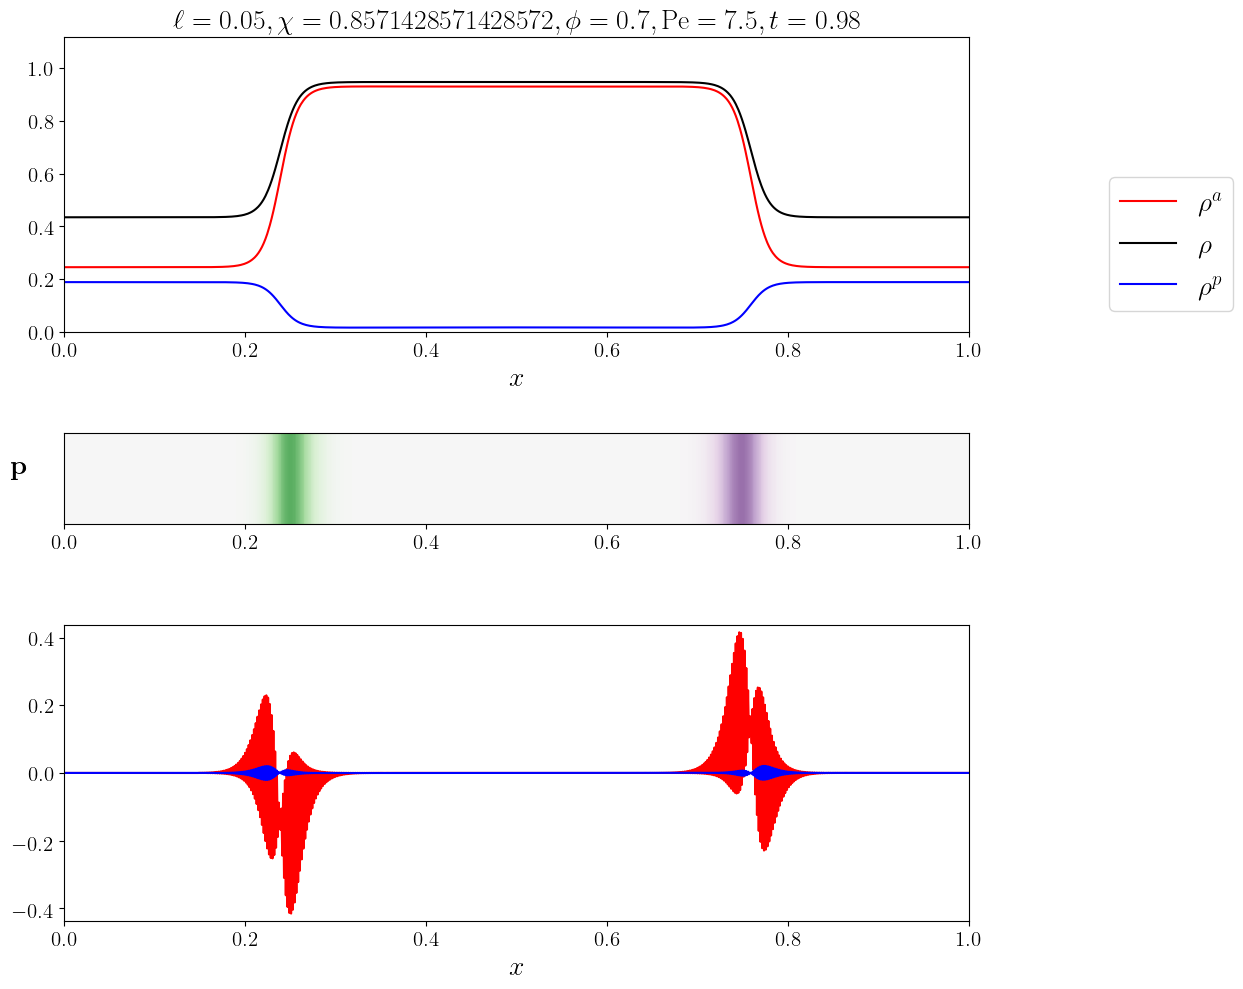

In [90]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
vid_pde_plot_pm_plus(fig, axs, param, [t], [fa], [fp], 1)
display(fig)

In [81]:
T = 1.1
save_interval = 0.001
run_pde_until_pm!(param,density,T; save_on = true, max_steps = max_steps, save_interval = save_interval)

250569

In [83]:
make_phase_video_pm(param; skip_factor = 1, ϕg =ϕg, ϕl = ϕl, start_time = 1.0)